In [1]:
import matplotlib
matplotlib.use('Agg')
% matplotlib inline 

from metro import multiplex as mx
from metro import assignment
from metro import utility
from metro import ita
from metro import viz

import pandas as pd
import numpy as np
import cProfile
import time
import networkx as nx
import matplotlib.pyplot as plt # convenience for plotting
from matplotlib import pylab
import seaborn as sns
pylab.rcParams['savefig.facecolor'] = 'black'
pylab.rcParams['savefig.dpi'] = 72 # should be ~300 for final figs

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
betas = [100, 1, 0.5, 0.1, 0.01]
sns.set_style("white")
sns.set_palette(sns.color_palette("Blues", len(betas)))
current_palette = sns.color_palette()

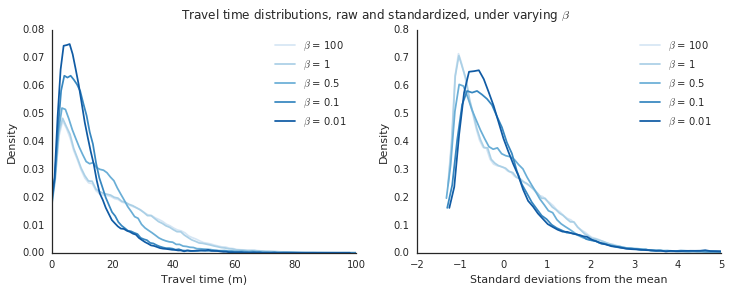

In [3]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

i = 0
for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    viz.weighted_hist(ax = ax1, 
                      measure = df.congested_time_m, 
                      weights = df.flow, 
                      label = r'$\beta$ = ' + str(beta),  
                      standardized = False)
    viz.weighted_hist(ax = ax2, 
                      measure = df.congested_time_m, 
                      weights = df.flow, 
                      label = r'$\beta$ = ' + str(beta),  
                      standardized = True)
    i += 1

ax1.legend()
ax2.legend()
ax1.set(xlim = (0,100), xlabel = 'Travel time (m)', ylabel = 'Density')
ax2.set(xlim = (-2, 5), xlabel = 'Standard deviations from the mean', ylabel = 'Density')
sns.despine()
fig.suptitle(r'Travel time distributions, raw and standardized, under varying $\beta$')
plt.savefig('4_figs/travel_time_distributions.png')

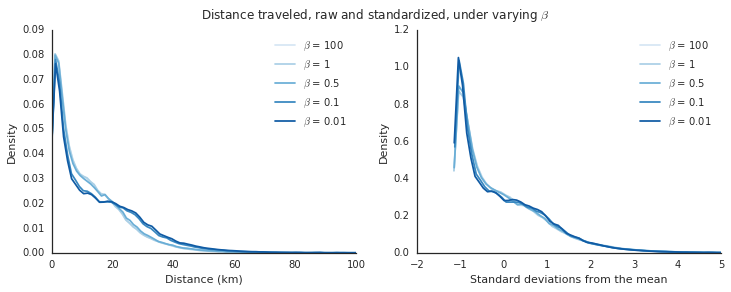

In [4]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

i = 0
for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    viz.weighted_hist(ax = ax1, 
                      measure = df.dist_km, 
                      weights = df.flow, 
                      label = r'$\beta$ = ' + str(beta),  
                      standardized = False)
    viz.weighted_hist(ax = ax2, 
                      measure = df.dist_km, 
                      weights = df.flow, 
                      label = r'$\beta$ = ' + str(beta),  
                      standardized = True)
    i += 1
    
ax1.legend()
ax2.legend()
ax1.set(xlim = (0,100), xlabel = 'Distance (km)', ylabel = 'Density')
ax2.set(xlim = (-2, 5), xlabel = 'Standard deviations from the mean', ylabel = 'Density')
sns.despine()
fig.suptitle(r'Distance traveled, raw and standardized, under varying $\beta$')
plt.savefig('4_figs/travel_distance_distributions.png')

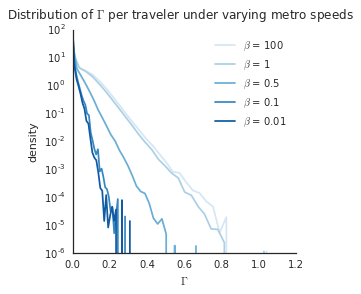

In [27]:
fig = plt.figure(figsize = (4,4))
ax1 = fig.add_subplot(111)

i = 0
for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    dg = df[df.gamma > 0]
    viz.weighted_hist(ax = ax1, 
                      measure = dg.gamma, 
                      weights = dg.flow, 
                      label = r'$\beta$ = ' + str(beta),  
                      standardized = False,
                      color = current_palette[i],
                      n = 30)
    i += 1
    
ax1.set_yscale('log')
ax1.set(xlabel = r'$\Gamma$', ylabel = 'density')

ax1.legend()
fig.suptitle(r'Distribution of $\Gamma$ per traveler under varying metro speeds')

sns.despine()

plt.savefig('4_figs/gamma_dist.png')

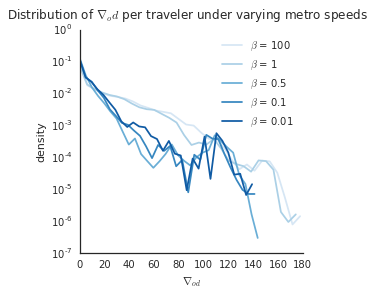

In [26]:
fig = plt.figure(figsize = (4,4))
ax1 = fig.add_subplot(111)

i = 0
for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    dg = df[df.gamma > 0]
    viz.weighted_hist(ax = ax1, 
                      measure = dg.gradient, 
                      weights = dg.flow, 
                      label = r'$\beta$ = ' + str(beta),  
                      standardized = False,
                      color = current_palette[i],
                      n = 30)
    i += 1

ax1.set_yscale('log')
ax1.set(xlabel = r'$\nabla_{od}$', ylabel = 'density')
ax1.legend()
fig.suptitle(r'Distribution of $\nabla_{od}$ per traveler under varying metro speeds')

sns.despine()

plt.savefig('4_figs/gradient_dist.png')

In [ ]:
def wavg_constructor(col, weights):    
    def wavg(group):
        d = group[col]
        w = group[weights]
        return (d * w).sum() / w.sum()
    return wavg

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)

i = 0
for beta in betas:
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    dg = df[df.gamma > 0]
    dg['bins'] = pd.cut(dg.dist_km, bins = 2*np.arange(50))

    dists = dg.groupby('bins').apply(wavg_constructor('dist_km', 'flow'))
    times = dg.groupby('bins').apply(wavg_constructor('congested_time_m', 'flow'))

    ax.plot(dists, times, color = current_palette[i])
    i += 1

ax.legend(loc = 2)
ax.set(xlabel = 'Distance traveled (km)', ylabel = 'Mean travel time (m)')
fig.suptitle('Travel time vs. distance under varying metro speeds')

sns.despine()

plt.save_fig('4_figs/time_v_distance.png')

In [9]:
from scipy import stats
import statsmodels.api as sm

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.iolib.table import (SimpleTable, default_txt_fmt)

In [10]:
# This is going in the right direction, but the computation of v_f needs correction 
# to scale with beta. Shouldn't be too hard. 

from collections import namedtuple 
def compute_serdars_alpha(beta):
    df = pd.read_csv('3_throughput/route_info_' + str(beta) + '.csv')
    dg = df[df.gamma > 0]
    mean_gamma = np.average(dg.gamma, weights = dg.flow)
    
    mod_wls = sm.WLS(dg.congested_time_m, 
                     np.c_[dg.dist_km,np.ones(len(dg))], 
                     weights=dg.flow)
    res_wls = mod_wls.fit()

    coef = res_wls.params.x1
    const = res_wls.params.const
    
    v_f = 1.0 # revisit
    alpha = np.log(coef * v_f) / np.log(1 + 4 * mean_gamma)
    return alpha, mean_gamma, coef, const, 

for beta in betas:
    print compute_serdars_alpha(beta)

(1.3038919048087181, 0.056514556326891681, 1.3043943247476453, 3.184467304715378)
(1.3881997355182223, 0.048502206372537014, 1.2790921757048259, 2.9379817119005964)
(-0.85282148751270648, 0.014186066072257957, 0.95402104459557036, 3.134732633400001)
(-41.861785997902075, 0.0039677760132033396, 0.51727761925803706, 4.1939827821476046)
(-66.702021501590323, 0.0031742133308820491, 0.43103139684123304, 4.230340692481386)


In [15]:
m = mx.read_multi()
layers = m.get_layers()

dists = nx.get_edge_attributes(m.G, 'dist_km')
times = nx.get_edge_attributes(m.G, 'free_flow_time_m')

speed_km_m = {key : dists[key]/times[key] for key in dists}
nx.set_edge_attributes(m.G, 'speed_km_m', speed_km_m)

m.mean_edge_attr_per(layers = ['street', 'metro'], attr = 'speed_km_m', weight_attr = 'dist_km')

KeyboardInterrupt: 